In [1]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from itertools import product

In [2]:
item_categories = pd.read_csv('data/item_categories.csv', index_col='item_category_id')
items = pd.read_csv('data/items.csv', index_col='item_id')
shops = pd.read_csv('data/shops.csv', index_col='shop_id')
train_X = pd.read_csv('data/train_dataset.csv')
test_df = pd.read_csv('data/test_dataset.csv')

In [3]:
other_test_df = test_df.groupby(['shop_id', 'item_id', 'date_block_num']).item_cnt_day.sum().unstack()
test_X = pd.DataFrame(map(list, other_test_df.index), columns=['shop_id', 'item_id'])
test_target = other_test_df[33]

In [4]:
train_X.groupby(['shop_id', 'item_id']).item_cnt_day.count().sort_values()

shop_id  item_id
38       1065         1
19       20057        1
41       6004         1
         6009         1
19       20072        1
                   ... 
42       20949      803
22       20949      824
31       20949      832
28       20949      837
53       20949      840
Name: item_cnt_day, Length: 417004, dtype: int64

In [15]:
shop_id = 53
item_id = 20949

In [16]:
series = train_df[(train_df.shop_id == shop_id) & (train_df.item_id == item_id)].groupby('date_block_num').item_cnt_day.sum()

In [18]:
y = test_df[(test_df.shop_id == shop_id) & (test_df.item_id == item_id)].item_cnt_day.sum()

# Some functions

In [4]:
def MSE(series_true, series_predicted):
    return sum((series_true - series_predicted)**2 / len(series_true))**0.5

In [5]:
def EMA(ser, alpha):
    y_1 = ser[0]
    for y in ser:
        y_1 = (1 - alpha) * y_1 + alpha * y
    return y_1

# Experiments

In [58]:
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima_model import ARMA

## ARIMA for month data

In [105]:
month_series = train_df[(train_df.shop_id == shop_id) & (train_df.item_id == item_id)].groupby('date_block_num').item_cnt_day.sum()
month_y = test_df[(test_df.shop_id == shop_id) & (test_df.item_id == item_id)].item_cnt_day.sum()

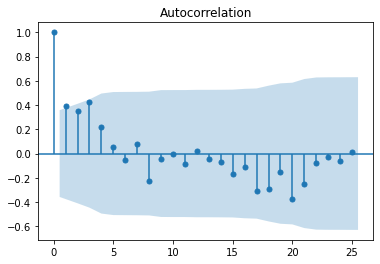

In [106]:
sm.graphics.tsa.plot_acf(month_series, lags=25);

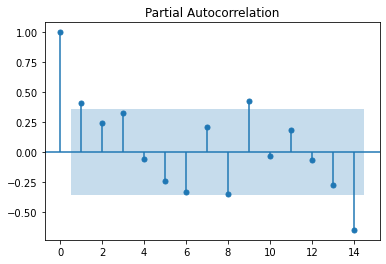

In [107]:
fig = sm.graphics.tsa.plot_pacf(month_series, lags=14);

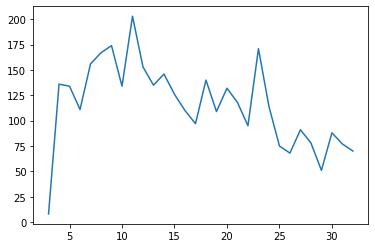

In [108]:
plt.plot(month_series)
plt.show()

In [109]:
test = sm.tsa.adfuller(month_series)
print('adf: ', test[0])
print('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print('есть единичные корни, ряд не стационарен')
else:
    print('единичных корней нет, ряд стационарен')

adf:  -0.7898213644472372
p-value:  0.8220936954595429
Critical values:  {'1%': -3.6996079738860943, '5%': -2.9764303469999494, '10%': -2.627601001371742}
есть единичные корни, ряд не стационарен


In [110]:
series_diff = month_series.diff().dropna()
test_diff = sm.tsa.adfuller(series_diff)
print('adf: ', test_diff[0])
print('p-value: ', test_diff[1])
print('Critical values: ', test_diff[4])
if test_diff[0]> test_diff[4]['5%']: 
    print('есть единичные корни, ряд не стационарен')
else:
    print('единичных корней нет, ряд стационарен')

adf:  -3.4283539175570596
p-value:  0.010029438569048822
Critical values:  {'1%': -3.7883858816542486, '5%': -3.013097747543462, '10%': -2.6463967573696143}
единичных корней нет, ряд стационарен


In [111]:
p, d, q = 3, 1, 2
arima = ARIMA(month_series, order=(p, d, q)).fit()

c:\users\user\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
c:\users\user\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
c:\users\user\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
c:\users\user\appdata\local\programs\python\python39\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.wa

In [112]:
arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           item_cnt_day   No. Observations:                   30
Model:                 ARIMA(3, 1, 2)   Log Likelihood                -142.045
Date:                Wed, 15 Sep 2021   AIC                            296.089
Time:                        10:00:02   BIC                            304.293
Sample:                             0   HQIC                           298.658
                                 - 30                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4496      0.293      1.533      0.125      -0.125       1.024
ar.L2         -0.3049      0.298     -1.023      0.306      -0.889       0.279
ar.L3          0.1387      0.314      0.442      0.658      -0.476       0.753
ma.L1         -1.2515      0.566     -2.212      0.027      -2.361      -0.142
ma.L2          0.9658      0.813      1.188      0.235      -0.627       2.559
sigma2       899.7551    650.611      1.383      0.167    -375.420    2174.930
===================================================================================
Ljung-Box (L1) (Q):                   1.27   Jarque-Bera (JB):                 2.68
Prob(Q):                              0.26   Prob(JB):                         0.26
Heteroskedasticity (H):               0.38   Skew:                             0.67
Prob(H) (two-sided):                  0.15   Kurtosis:                         3.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

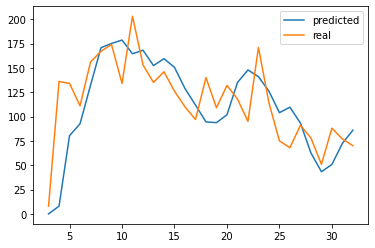

In [113]:
plt.plot(arima.predict())
plt.plot(month_series)
plt.legend(['predicted', 'real'])
plt.show()

c:\users\user\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


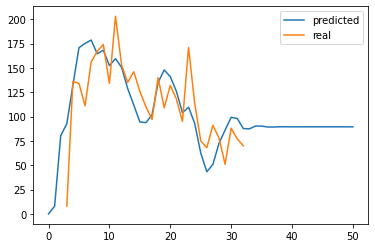

In [114]:
plt.plot(arima.predict(end=50))
plt.plot(month_series)
plt.legend(['predicted', 'real'])
plt.show()

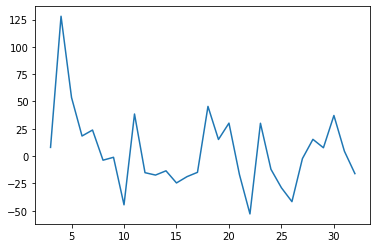

In [116]:
error = month_series - arima.predict()
plt.plot(error)
plt.show()

<AxesSubplot:>

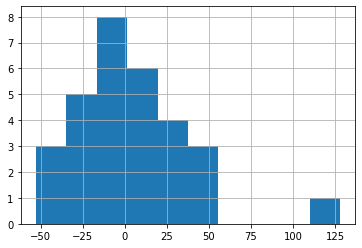

In [117]:
error.hist()

In [118]:
MSE(month_series, arima.predict())

35.34647206580642

## ARMA for week data

In [56]:
week_series = train_df[(train_df.shop_id == shop_id) & (train_df.item_id == item_id)].groupby('weeks').item_cnt_day.sum()

In [57]:
test = sm.tsa.adfuller(week_series)
print('adf: ', test[0])
print('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print('есть единичные корни, ряд не стационарен')
else:
    print('единичных корней нет, ряд стационарен')

adf:  -6.1043191255224825
p-value:  9.6665604927332e-08
Critical values:  {'1%': -3.4833462346078936, '5%': -2.8847655969877666, '10%': -2.5791564575459813}
единичных корней нет, ряд стационарен


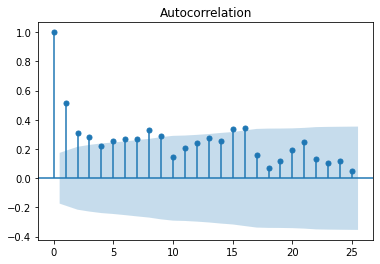

In [59]:
sm.graphics.tsa.plot_acf(week_series, lags=25);

In [67]:
p, d, q = 8, 0, 6
arma = ARIMA(week_series, order=(p, d, q)).fit()

c:\users\user\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
c:\users\user\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
c:\users\user\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
c:\users\user\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starti

In [68]:
arma.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           item_cnt_day   No. Observations:                  127
Model:                 ARIMA(8, 0, 6)   Log Likelihood                -460.234
Date:                Wed, 15 Sep 2021   AIC                            952.469
Time:                        09:50:06   BIC                            997.976
Sample:                             0   HQIC                           970.957
                                - 127                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         27.2141      8.909      3.055      0.002       9.753      44.676
ar.L1          0.6759      0.420      1.609      0.108      -0.148       1.499
ar.L2         -0.4764      0.381     -1.250      0.211      -1.223       0.270
ar.L3          0.2556      0.289      0.884      0.377      -0.311       0.823
ar.L4          0.2785      0.360      0.774      0.439      -0.426       0.984
ar.L5         -0.4655      0.308     -1.512      0.130      -1.069       0.138
ar.L6          0.6994      0.317      2.208      0.027       0.079       1.320
ar.L7         -0.2159      0.174     -1.239      0.215      -0.557       0.125
ar.L8          0.1836      0.126      1.460      0.144      -0.063       0.430
ma.L1         -0.2174      0.451     -0.482      0.630      -1.102       0.667
ma.L2          0.3457      0.536      0.645      0.519      -0.705       1.396
ma.L3         -0.0321      0.531     -0.061      0.952      -1.072       1.008
ma.L4         -0.4355      0.409     -1.064      0.287      -1.237       0.366
ma.L5          0.5196      0.476      1.092      0.275      -0.413       1.452
ma.L6         -0.5960      0.414     -1.440      0.150      -1.407       0.215
sigma2        78.8996     26.827      2.941      0.003      26.319     131.480
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                44.17
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.03   Skew:                             1.07
Prob(H) (two-sided):                  0.92   Kurtosis:                         4.93
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

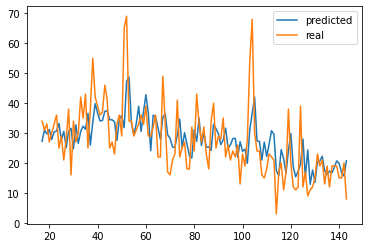

In [69]:
plt.plot(arma.predict())
plt.plot(week_series)
plt.legend(['predicted', 'real'])
plt.show()

<AxesSubplot:>

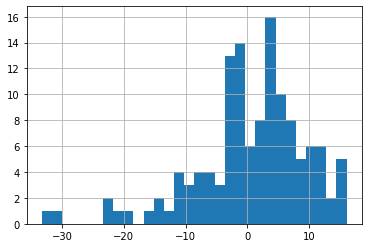

In [74]:
(arma.predict() - week_series).hist(bins=30)

In [79]:
MSE(week_series, arma.predict())

9.033604280596286

## Standart algorithms

In [132]:
window = 12
week_df = pd.DataFrame({f'feature_{i}': week_series[i: i + len(week_series) - window].array for i in range(window)})
week_df['target'] = week_series[window:].array

In [135]:
week_df.head()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,target
0,34.0,31.0,33.0,27.0,30.0,33.0,36.0,25.0,29.0,21.0,28.0,38.0,16.0
1,31.0,33.0,27.0,30.0,33.0,36.0,25.0,29.0,21.0,28.0,38.0,16.0,34.0
2,33.0,27.0,30.0,33.0,36.0,25.0,29.0,21.0,28.0,38.0,16.0,34.0,27.0
3,27.0,30.0,33.0,36.0,25.0,29.0,21.0,28.0,38.0,16.0,34.0,27.0,30.0
4,30.0,33.0,36.0,25.0,29.0,21.0,28.0,38.0,16.0,34.0,27.0,30.0,42.0


In [136]:
from sklearn.tree import DecisionTreeRegressor

In [154]:
week_tree = DecisionTreeRegressor(max_depth=10)

In [155]:
week_tree.fit(week_df.drop('target', axis=1), week_df.target)

DecisionTreeRegressor(max_depth=10)

In [157]:
week_tree_predicted = week_tree.predict(week_df.drop('target', axis=1))

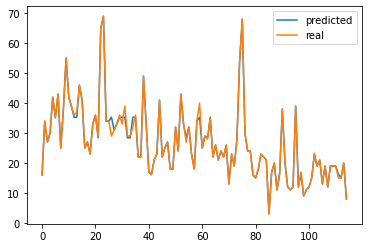

In [160]:
plt.plot(week_tree_predicted)
plt.plot(week_df.target)
plt.legend(['predicted', 'real'])
plt.show()

In [147]:
window = 4
month_df = pd.DataFrame({f'feature_{i}': month_series[i: i + len(month_series) - window].array for i in range(window)})
month_df['target'] = month_series[window:].array

In [180]:
month_tree = DecisionTreeRegressor(max_depth=5)

In [181]:
month_tree.fit(month_df.drop('target', axis=1), month_df.target)

DecisionTreeRegressor(max_depth=5)

In [182]:
month_tree_predicted = month_tree.predict(month_df.drop('target', axis=1))

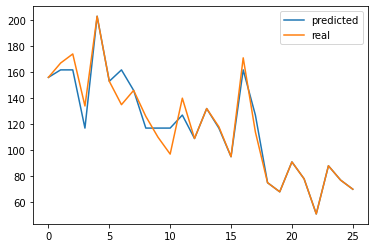

In [183]:
plt.plot(month_tree_predicted)
plt.plot(month_df.target)
plt.legend(['predicted', 'real'])
plt.show()

In [184]:
month_tree.predict(pd.DataFrame({f'feature_{i}': [month_series[len(month_series) - window + i]] for i in range(window)}))

array([88.])

In [185]:
month_y

73.0

## Predicting all

In [4]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso

In [5]:
train_df.date.unique()

array(['2013-01-01', '2013-01-02', '2013-01-03', ..., '2015-09-28',
       '2015-09-29', '2015-09-30'], dtype=object)

In [6]:
test_df.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id,total_income,days,weeks
0,2015-10-01,33,9,20631,699.0,2.0,72,1398.0,1003,143
1,2015-10-01,33,9,20612,1099.0,1.0,72,1099.0,1003,143
2,2015-10-01,33,55,7102,229.0,1.0,31,229.0,1003,143
3,2015-10-01,33,9,4201,399.0,1.0,75,399.0,1003,143
4,2015-10-01,33,55,7667,6900.0,1.0,76,6900.0,1003,143


In [13]:
train_tups = set(map(tuple, train_df[['shop_id', 'item_id']].values))

In [14]:
test_tups = set(map(tuple, test_df[['shop_id', 'item_id']].values))

In [16]:
len(train_tups.difference(test_tups))

392593

In [17]:
len(test_tups.difference(train_tups))

7120

### class MyAbstractModel

In [5]:
# divide into two classes because of model_init
class MyAbstractModel:
    def __init__(self, model_init, *model_args, **model_kwargs):
        self.model_init = model_init
        self.model_args = model_args
        self.model_kwargs = model_kwargs
        
    def fit(self, X_train):
        self.all_series = X_train.groupby(
            ['shop_id', 'item_id', 'date_block_num']).item_cnt_day.sum().unstack(fill_value=0)

    def predict_shop_item(self, shop_id, item_id):
        return None

    def predict(self, X):
        return [self.predict_shop_item(shop_id, item_id) for shop_id, item_id in X[['shop_id', 'item_id']].values]

### class MyModel

In [38]:
class MyModel(MyAbstractModel):
    def __init__(self, model_init, window=12, *model_args, **model_kwargs):
        MyAbstractModel.__init__(self, model_init, *model_args, **model_kwargs)
        self.window = window

    def predict_shop_item(self, shop_id, item_id):
        try:
            ser = list(self.all_series.loc[(shop_id, item_id)])
        except KeyError as e:
            return 0
        window_df = pd.DataFrame([ser[k : k + self.window] for k in range(len(ser) - self.window + 1)])
        X, y = window_df.drop(columns=[self.window - 1]), window_df[self.window - 1]
        model = self.model_init(*self.model_args, **self.model_kwargs)
        model.fit(X, y)
        return model.predict(pd.DataFrame([ser[-self.window + 1:]]))[0]

In [18]:
my_model = MyModel(DecisionTreeRegressor, window=10, max_depth=6)

In [19]:
my_model.fit(train_X)

In [20]:
my_model.predict_shop_item(53, 20949)

70.0

In [16]:
train_df.groupby(['shop_id', 'item_id']).item_cnt_day.count().sort_values()

shop_id  item_id
38       1065         1
19       20057        1
41       6004         1
         6009         1
19       20072        1
                   ... 
42       20949      803
22       20949      824
31       20949      832
28       20949      837
53       20949      840
Name: item_cnt_day, Length: 417004, dtype: int64

In [24]:
predicted = my_model.predict(test_X)

In [25]:
MSE(test_target, predicted)

10.543114299603069

In [153]:
test_df.shape

(53514, 10)

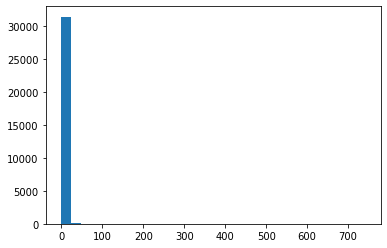

In [101]:
plt.hist(predicted, bins=30)
plt.show()

In [102]:
pd.Series(predicted).describe()

count    31531.000000
mean         1.135084
std          6.857297
min         -1.000000
25%          0.000000
50%          0.055556
75%          1.000000
max        742.000000
dtype: float64

In [94]:
my_model_2 = MyModel(DecisionTreeRegressor, window=6, max_depth=6)

In [96]:
my_model_2.fit(train_df)

In [97]:
predicted_2 = my_model_2.predict(test_X)

In [98]:
MSE(test_target, predicted_2)

13.898492364884332

In [104]:
my_model_3 = MyModel(Ridge)

In [106]:
my_model_3.fit(train_df)

In [107]:
predicted_3 = my_model_3.predict(test_X)

In [108]:
MSE(test_target, predicted_3)

1898.6489846839138

In [110]:
alpha_params = 10.**np.arange(-1, 4)
MSEs = {}
for alpha in alpha_params:
    model = MyModel(Ridge)
    model.fit(train_df)
    predicted = model.predict(test_X)
    MSEs[alpha] = MSE(test_target, predicted)
    print('alpha:', alpha, '    MSE:', MSEs[alpha])

alpha: 0.1     MSE: 1898.6489846839138
alpha: 1.0     MSE: 1898.6489846839138
alpha: 10.0     MSE: 1898.6489846839138
alpha: 100.0     MSE: 1898.6489846839138
alpha: 1000.0     MSE: 1898.6489846839138


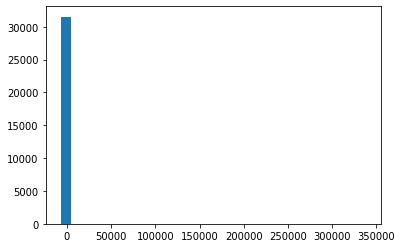

In [114]:
plt.hist(predicted, bins=30)
plt.show()

In [116]:
np.percentile(predicted, 99.9)

156.47142854391814

In [118]:
sorted(predicted)[:10]

[-6795.269084692509,
 -592.4444017037243,
 -507.65511301872596,
 -351.9210288952907,
 -218.87199702798603,
 -183.0465896188096,
 -165.6014069672668,
 -151.90792787166697,
 -151.07074410310165,
 -148.4235788604006]

In [119]:
sorted(predicted)[-10:]

[444.5917292848238,
 480.1489974725545,
 533.8187756147161,
 591.1999235705898,
 721.6887736198589,
 752.1846209999062,
 828.1535152570614,
 1019.8245016625431,
 1346.7061570819865,
 337557.1194525762]

In [120]:
np.array(predicted).argmax()

4812

In [122]:
test_X.loc[4812]

shop_id       12
item_id    20949
Name: 4812, dtype: int64

In [134]:
mmodel = MyModel(Ridge, alpha=1)

In [135]:
mmodel.fit(train_df)

In [136]:
mmodel.predict_shop_item(12, 20949)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 500.0, 1000.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[   0.            0.          337.50683008 -168.80437943   84.35358798
  -42.23062734   21.07219672  -10.60077471    5.27889316   -2.74733685
    1.43858634]


337557.1194525762

In [28]:
all_series = train_df.groupby(
            ['shop_id', 'item_id', 'date_block_num']).item_cnt_day.sum().unstack(fill_value=0)

In [61]:
all_series[((all_series[list(range(20))] == 0).sum(axis=1) == 20)]

date_block_num    0    1    2    3    4    5    6    7    8    9   ...   23  \
shop_id item_id                                                    ...        
2       53       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
        59       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
        67       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
        70       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
        257      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
...              ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
59      22106    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
        22118    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
        22139    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
        22162    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
        22164    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   

date_block_num    24   25   26   27   28   29   30   31   32  
shop_id item_id                                               
2       53       0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
        59       0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
        67       1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
        70       0.0  0.0  0.0  1.0  0.0  0.0  0.0  1.0  0.0  
        257      0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
...              ...  ...  ...  ...  ...  ...  ...  ...  ...  
59      22106    1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
        22118    0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  
        22139    1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  
        22162    0.0  9.0  4.0  1.0  1.0  0.0  0.0  1.0  0.0  
        22164    0.0  2.0  1.0  2.0  0.0  0.0  1.0  0.0  0.0  

[90009 rows x 33 columns]

In [87]:
all_series

date_block_num    0     1    2    3    4    5    6    7    8    9   ...   23  \
shop_id item_id                                                     ...        
0       30       0.0  31.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
        31       0.0  11.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
        32       6.0  10.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
        33       3.0   3.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
        35       1.0  14.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
...              ...   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
59      22154    1.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
        22155    0.0   0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  ...  0.0   
        22162    0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
        22164    0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
        22167    0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  ...  0.0   

date_block_num    24   25   26   27   28   29   30   31   32  
shop_id item_id                                               
0       30       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
        31       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
        32       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
        33       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
        35       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
...              ...  ...  ...  ...  ...  ...  ...  ...  ...  
59      22154    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
        22155    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
        22162    0.0  9.0  4.0  1.0  1.0  0.0  0.0  1.0  0.0  
        22164    0.0  2.0  1.0  2.0  0.0  0.0  1.0  0.0  0.0  
        22167    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[417004 rows x 33 columns]

In [45]:
my_model.predict_shop_item(59, 22162)

0.5294117647058824

In [47]:
lin_reg_model = MyModel(LinearRegression)

In [48]:
lin_reg_model.fit(train_df)

In [49]:
lin_reg_predicted = lin_reg_model.predict(test_X)

In [50]:
MSE(test_target, lin_reg_predicted)

113878915037619.22

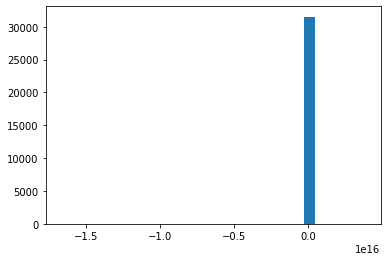

In [55]:
plt.hist(lin_reg_predicted, bins=30)
plt.show()

In [151]:
other_mmodel = MyOtherModel(Ridge, alpha=1)

In [152]:
other_mmodel.fit(train_df)

In [153]:
other_mmodel.predict_shop_item(12, 20949)

8.734003199999997

In [43]:
boosting_model = MyModel(GradientBoostingRegressor, n_estimators=50)
boosting_model.fit(train_X)
boosting_model_predicted = boosting_model.predict(test_X)
MSE(test_target, boosting_model_predicted)

11.308963570528544

### class MyOtherModel

In [24]:
class MyOtherModel(MyAbstractModel):
    def __init__(self, model_init, window=12, *model_args, **model_kwargs):
        MyAbstractModel.__init__(self, model_init, *model_args, **model_kwargs)
        self.window = window

    def predict_shop_item(self, shop_id, item_id):
        try:
            ser = list(self.all_series.loc[(shop_id, item_id)])
        except KeyError as e:
            return 0
        if all(np.array(ser)[:-self.window] == 0):
            return EMA(ser, 0.4)
        window_df = pd.DataFrame([ser[k : k + self.window] for k in range(len(ser) - self.window + 1)])
        X, y = window_df.drop(columns=[self.window - 1]), window_df[self.window - 1]
        model = self.model_init(*self.model_args, **self.model_kwargs)
        model.fit(X, y)
        return model.predict(pd.DataFrame([ser[-self.window + 1:]]))[0]

In [154]:
other_model = MyOtherModel(DecisionTreeRegressor, window=10, max_depth=6)

In [155]:
other_model.fit(train_df)

In [156]:
other_predicted = other_model.predict(test_X)

In [157]:
MSE(test_target, other_predicted)

10.161748912401112

In [166]:
for window in range(6, 13):
    model = MyOtherModel(DecisionTreeRegressor, window=window, max_depth=6)
    model.fit(train_df)
    predicted = model.predict(test_X)
    print('window:', window)
    print('MSE:', MSE(test_target, predicted))

window: 6
MSE: 13.821688292128732
window: 7
MSE: 10.380090475260893
window: 8
MSE: 10.259780182325331
window: 9
MSE: 10.908684711041696
window: 10
MSE: 10.476324097645731
window: 11
MSE: 10.256466709709299
window: 12
MSE: 10.557158510510032


In [30]:
other_model_3 = MyOtherModel(RandomForestRegressor, max_depth=6, n_estimators=10)

In [31]:
other_model_3.fit(train_X)

In [32]:
other_predicted_3 = other_model_3.predict(test_X)

In [33]:
MSE(test_target, other_predicted_3)

11.254962777394418

### class LinRegModel

In [34]:
from sklearn.preprocessing import StandardScaler

In [35]:
class LinRegModel(MyAbstractModel):
    def __init__(self, penalty='l2', window=12, *model_args, **model_kwargs):
        if penalty == 'l2':
            model_init = Ridge
        elif penalty == 'l1':
            model_init = Lasso
        else:
            model_init= LinearRegression
        MyAbstractModel.__init__(self, model_init, *model_args, **model_kwargs)
        self.window = window
    
    def predict_shop_item(self, shop_id, item_id):
        try:
            ser = list(self.all_series.loc[(shop_id, item_id)])
        except KeyError as e:
            return 0
        if all(np.array(ser)[:-self.window] == 0):
            return EMA(ser, 0.4)
        
        window_df = pd.DataFrame([ser[k : k + self.window] for k in range(len(ser) - self.window + 1)])
        X, y = window_df.drop(columns=[self.window - 1]), window_df[self.window - 1]
        
        scaler = StandardScaler()
        X = scaler.fit_transform(X)
        
        model = self.model_init(*self.model_args, **self.model_kwargs)
        model.fit(X, y)
        test_X = scaler.transform(pd.DataFrame([ser[-self.window + 1:]]))
        return model.predict(test_X)[0]

In [36]:
ridge_model = LinRegModel(penalty='l2', window=12, alpha=1.0)

In [37]:
ridge_model.fit(train_X)

In [38]:
ridge_predicted = ridge_model.predict(test_X)

In [39]:
MSE(test_target, ridge_predicted)

13.401348790127614

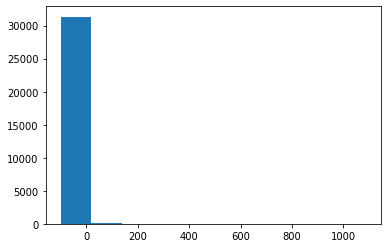

In [40]:
plt.hist(ridge_predicted)
plt.show()

In [50]:
test_X[np.array(ridge_predicted) > 500]

,shop_id,item_id
4531,12,11370
12915,25,20949
17224,31,20949


In [51]:
ridge_model.predict_shop_item(12, 11370)

1085.9536592157317

### class OnlyEMA

In [61]:
class OnlyEMA(MyAbstractModel):
    def __init__(self, alpha=0.4):
        self.alpha = alpha
    def predict_shop_item(self, shop_id, item_id):
        try:
            ser = list(self.all_series.loc[(shop_id, item_id)])
        except KeyError as e:
            return 0
        return EMA(ser, self.alpha)  

In [63]:
ema_model = OnlyEMA()

In [64]:
ema_model.fit(train_X)

In [65]:
ema_predicted = ema_model.predict(test_X)

KeyboardInterrupt: 

In [60]:
MSE(test_target, ema_predicted)

12.552665282646151

In [68]:
mses = []
for alpha in np.arange(1, 10) / 10:
    ema_model = OnlyEMA(alpha)
    ema_model.fit(train_X)
    ema_predicted = ema_model.predict(test_X)
    mses.append(MSE(test_target, ema_predicted))

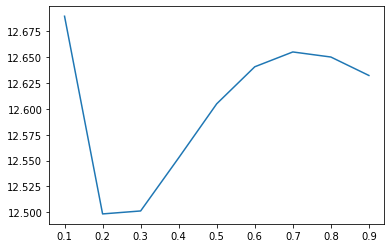

In [69]:
plt.plot(np.arange(1, 10) / 10, mses)
plt.show()

In [71]:
mses = np.array(mses)
print('min mse:', mses.min())
print('alpha:', mses.argmin())

min mse: 12.49847259200977
alpha: 1


### class PartEMAModel

In [8]:
class PartEMAModel(MyAbstractModel):
    def __init__(self, model_init, threshold, window=12, alpha=0.2, *model_args, **model_kwargs):
        MyAbstractModel.__init__(self, model_init, *model_args, **model_kwargs)
        self.window = window
        self.alpha = alpha
        self.threshold = threshold
    
    def predict_shop_item(self, shop_id, item_id):
        try:
            ser = list(self.all_series.loc[(shop_id, item_id)])
        except KeyError as e:
            return 0
        if all(np.array(ser)[:self.threshold] == 0):
            return EMA(ser[self.threshold:], self.alpha)

        window_df = pd.DataFrame([ser[k : k + self.window] for k in range(len(ser) - self.window + 1)])
        X, y = window_df.drop(columns=[self.window - 1]), window_df[self.window - 1]
        
        model = self.model_init(*self.model_args, **self.model_kwargs)
        model.fit(X, y)
        return model.predict(pd.DataFrame([ser[-self.window + 1:]]))[0]

In [86]:
part_ema_model = PartEMAModel(DecisionTreeRegressor, threshold=10, max_depth=6)

In [87]:
part_ema_model.fit(train_X)

In [88]:
part_ema_predicted = part_ema_model.predict(test_X)

In [89]:
MSE(part_ema_predicted, test_target)

10.195765297638657

In [102]:
part_ema_model_2 = PartEMAModel(DecisionTreeRegressor, threshold=20, max_depth=6)

In [103]:
part_ema_model_2.fit(train_X)

In [105]:
part_ema_predicted_2 = part_ema_model_2.predict(test_X)

In [106]:
MSE(part_ema_predicted_2, test_target)

10.254528873642665

In [107]:
part_ema_mses = []
for threshold in range(1, 33):
    part_ema_model = PartEMAModel(DecisionTreeRegressor, threshold=threshold, max_depth=6)
    part_ema_model.fit(train_X)
    part_ema_predicted = part_ema_model.predict(test_X)
    part_ema_mses.append(MSE(part_ema_predicted, test_target))

<IPython.core.display.Javascript object>


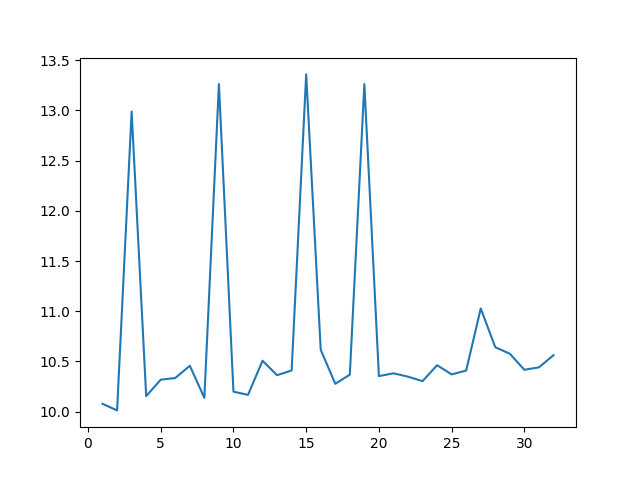

In [112]:
plt.plot(range(1, 33), part_ema_mses)
plt.show()

In [109]:
part_ema_mses = np.array(part_ema_mses)
part_ema_mses.min()

10.012887571669099

In [110]:
part_ema_mses.argmin()

1

array([10.07823778, 10.01288757, 12.98915311, 10.15492798, 10.31857908,
       10.33531247, 10.4571842 , 10.13784233, 13.26140228, 10.19948988,
       10.16729846, 10.50736734, 10.36327664, 10.41079509, 13.35792667,
       10.61605286, 10.27766116, 10.36860359, 13.26077024, 10.35419101,
       10.38220146, 10.34867258, 10.3041026 , 10.46287163, 10.37136145,
       10.40970574, 11.02757525, 10.64214089, 10.57695813, 10.41717924,
       10.44128837, 10.56203643])

In [115]:
part_ema_model_2 = PartEMAModel(DecisionTreeRegressor, threshold=20, max_depth=6)
part_ema_model_2.fit(train_X)
part_ema_predicted_2 = part_ema_model_2.predict(test_X)
MSE(part_ema_predicted_2, test_target)

13.294193319326052

In [116]:
part_ema_model_2 = PartEMAModel(DecisionTreeRegressor, threshold=20, max_depth=6)
part_ema_model_2.fit(train_X)
part_ema_predicted_2 = part_ema_model_2.predict(test_X)
MSE(part_ema_predicted_2, test_target)

13.205236282105133

### class PartEMAAndConstModel

In [28]:
class PartEMAAndConstModel(MyAbstractModel):
    def __init__(self, model_init, ema_threshold, const_threshold, window=12, alpha=0.4, *model_args, **model_kwargs):
        MyAbstractModel.__init__(self, model_init, *model_args, **model_kwargs)
        self.window = window
        self.ema_threshold = ema_threshold
        self.const_threshold = const_threshold
        self.alpha = alpha
    
    def predict_shop_item(self, shop_id, item_id):
        try:
            ser = list(self.all_series.loc[(shop_id, item_id)])
        except KeyError as e:
            return 0
        
        if all(np.array(ser)[self.const_threshold:] == 0):
            return 0
        
        if all(np.array(ser)[:self.ema_threshold] == 0):
            return EMA(ser[self.ema_threshold:], self.alpha)

        window_df = pd.DataFrame([ser[k : k + self.window] for k in range(len(ser) - self.window + 1)])
        X, y = window_df.drop(columns=[self.window - 1]), window_df[self.window - 1]
        
        model = self.model_init(*self.model_args, **self.model_kwargs)
        model.fit(X, y)
        return model.predict(pd.DataFrame([ser[-self.window + 1:]]))[0]        

In [29]:
part_ema_and_const_model = PartEMAAndConstModel(DecisionTreeRegressor, 2, -4, max_depth=6)

In [30]:
part_ema_and_const_model.fit(train_X)

In [31]:
part_ema_and_const_predicted = part_ema_and_const_model.predict(test_X)

In [32]:
MSE(test_target, part_ema_and_const_predicted)

9.998569429137785

In [36]:
mses = {}
for const_threshold, ema_threshold in product(range(-1, -5, -1), range(2, 22, 4)):
    part_ema_and_const_model_2 = PartEMAAndConstModel(DecisionTreeRegressor, ema_threshold, const_threshold, max_depth=6)
    part_ema_and_const_model_2.fit(train_X)
    part_ema_and_const_predicted_2 = part_ema_and_const_model_2.predict(test_X)
    mses[(const_threshold, ema_threshold)] = MSE(test_target, part_ema_and_const_predicted_2)
    print('const_threshold:', const_threshold)
    print('ema_treshold:', ema_threshold)
    print('MSE:', mses[(const_threshold, ema_threshold)])
    print('------------------------------------------')

const_threshold: -1
ema_treshold: 2
MSE: 10.065178986102556
------------------------------------------
const_threshold: -1
ema_treshold: 6
MSE: 13.360293931698672
------------------------------------------
const_threshold: -1
ema_treshold: 10
MSE: 10.3020412139954
------------------------------------------
const_threshold: -1
ema_treshold: 14
MSE: 13.23761182634297
------------------------------------------
const_threshold: -1
ema_treshold: 18
MSE: 10.486323183709885
------------------------------------------
const_threshold: -2
ema_treshold: 2
MSE: 13.068600910274565
------------------------------------------
const_threshold: -2
ema_treshold: 6
MSE: 10.342856655879395
------------------------------------------
const_threshold: -2
ema_treshold: 10
MSE: 10.444131601467358
------------------------------------------
const_threshold: -2
ema_treshold: 14
MSE: 10.465797716144891
------------------------------------------
const_threshold: -2
ema_treshold: 18
MSE: 10.417866623002128
----------

### class PartlyConstModel

In [44]:
class PartlyConstModel(MyAbstractModel):
    def __init__(self, model_init, const_threshold, window=12, *model_args, **model_kwargs):
        MyAbstractModel.__init__(self, model_init, *model_args, **model_kwargs)
        self.window = window
        self.const_threshold = const_threshold
    
    def predict_shop_item(self, shop_id, item_id):
        try:
            ser = list(self.all_series.loc[(shop_id, item_id)])
        except KeyError as e:
            return 1
        
        if all(np.array(ser)[self.const_threshold:] == 0):
            return 0        

        window_df = pd.DataFrame([ser[k : k + self.window] for k in range(len(ser) - self.window + 1)])
        X, y = window_df.drop(columns=[self.window - 1]), window_df[self.window - 1]
        
        model = self.model_init(*self.model_args, **self.model_kwargs)
        model.fit(X, y)
        return model.predict(pd.DataFrame([ser[-self.window + 1:]]))[0]        

In [46]:
partly_const_model = PartlyConstModel(DecisionTreeRegressor, -4, max_depth=10)
partly_const_model.fit(train_X)
partly_const_predicted = partly_const_model.predict(test_X)
MSE(test_target, partly_const_predicted)

10.464287673468128

### class MeanModel

In [50]:
class MeanModel(MyAbstractModel):
    def __init__(self):
        pass
    def predict_shop_item(self, shop_id, item_id):
        try:
            ser = list(self.all_series.loc[(shop_id, item_id)])
        except KeyError as e:
            return 2
        return np.mean(ser)

In [51]:
mean_model = MeanModel()
mean_model.fit(train_X)
mean_predicted = mean_model.predict(test_X)
MSE(test_target, mean_predicted)

13.05963379903199